### Eulerian autocovariance  filtered and demodulated signal
cf github/zcasparco/equinox_phd/llc4320/signal_filtering_store.ipynb for filtering and demodulation method

In [15]:
import numpy as np
import geopandas as gpd


import xarray as xr
from matplotlib import pyplot as plt
%matplotlib inline

from xhistogram.xarray import histogram
import dask.dataframe as dd
#import cartopy.crs as ccrs
#import cartopy.feature as cfeature

import mitequinox.utils as ut
from mitequinox.plot import *
import mitequinox.parcels as pa
from xmitgcm import llcreader

from scipy import signal
import scipy.ndimage as im
import scipy.optimize as opt

from sympy import Symbol, pi, atan, factor, lambdify

import mitequinox.plot as pl
import mitequinox.sigp as sp

from fsspec.implementations.local import LocalFileSystem

In [16]:
from dask.distributed import Client, LocalCluster
#
cluster = LocalCluster()
#
from dask_jobqueue import PBSCluster
#cluster = PBSCluster(walltime='02:00:00') #processes=7, cores=7
#w = cluster.scale(jobs=2)
#
client = Client(cluster)

In [3]:
# Definition of the functions to compute the correlation
def correlate_E(v1, v2, dt=None, roll=False, detrend=True, ufunc=True,**kwargs):
    ''' Compute a lagged correlation between two time series
    These time series are assumed to be regularly sampled in time 
    and along the same time line.
    
    Parameters
    ----------
    
        v1, v2: ndarray, pd.Series
            Time series to correlate, the index must be time if dt is not provided
            
        dt: float, optional
            Time step
            
        detrend: boolean, optional
            Turns detrending on or off. Default is False.

    See: https://docs.scipy.org/doc/numpy/reference/generated/numpy.correlate.html
    '''
    
    assert v1.shape == v2.shape
    
    if not ufunc:
        v1 = v1.transpose((2,1,0))
        v2 = v2.transpose((2,1,0))
    
    if detrend and not roll:
        v1 = signal.detrend(v1)
        v2 = signal.detrend(v2)
        _correlate = np.correlate
        _kwargs = {'mode': 'valid'}
        N = int(v1.shape[-1]/2)
    else:
        _correlate = roll_correlate
        #if _ds1.dtype=='complex128':
        #    _kwargs = {'mode': 'full','detrend':detrend}
        #else:
        _kwargs = {'mode': 'valid','detrend':detrend}
    _kwargs.update(**kwargs)
    
    # loop over all dimensions but the last one to apply correlate
    Ni = v1.shape[:-1]
    # infer number of lags from dummy computation
    i0 = tuple(0 for i in Ni) + np.s_[:,]
    f = _correlate(v1[i0], v2[i0], **_kwargs)
    vv = np.full(Ni+f.shape, np.NaN)
    for ii in np.ndindex(Ni):
        f = _correlate(v1[ii + np.s_[:,]], v2[ii + np.s_[:,]], **_kwargs)
        Nj = f.shape
        for jj in np.ndindex(Nj):
            vv[ii + jj] = f[jj]
    
    # select only positive lags
    #vv = vv[...,:]
    
    if ufunc:
        return vv
    else:
        lags = np.arange(vv.shape[-1])*dt
        vv = vv.transpose((2,1,0))
        return lags, vv

def roll_correlate(v1, v2, Nr=None, overlap=0.5, detrend=True, **kwargs):
    ''' Correlation over temporal windows of size Nr with overlap
    '''
    i=0
    C=[]
    while i+Nr<v1.size:
        _v1 = v1[i:i+Nr]
        _v2 = v2[i:i+Nr]
        if detrend:
            _v1 = signal.detrend(_v1)
            _v2 = signal.detrend(_v2)
        C+=[np.correlate(_v1[Nr//2:], _v2, **kwargs)/(Nr/2)]
        i+=int((1-overlap)*Nr)
        
    return np.mean(np.stack(C), axis=0)
    
# quick tests
#v1 = ds.u.isel(x_u=slice(0,10), y_rho=slice(0,10)).values.transpose((1,2,0))
#v1_cor = correlate(v1, v1, dt=1/24/6)
#v1_cor = roll_correlate(v1[0,0,:], v1[0,0,:], Nr=6*24*20, overlap=0)
#v1_cor = correlate(v1, v1, roll=True, Nr=6*24*20, overlap=0)
# Wrapping function
def wrap_correlate(v1, v2, dt, lags=None, **kwargs):
    #_v1,_v2 = v1.copy().load(),v2.copy().load()
    _v1,_v2 = v1,v2
    _v1 = _v1.chunk({'time': -1})
    _v2 = _v2.chunk({'time': -1})
    if lags is None:
        lags, C = correlate_E(_v1.values, _v2.values, dt=dt, ufunc=False, **kwargs)
        return lags, C
    else:
        #lags = np.arange(0,T//2+dt,dt)[:T//2*1/dt+1]
        if _v1.dtype=='complex128':
            dtype=np.complex128
        else:
            dtype=np.float64
        C = xr.apply_ufunc(correlate_E, _v1, _v2,
                    dask='parallelized', output_dtypes=[dtype], #np.float64
                    input_core_dims=[['time'], ['time']],
                    output_core_dims=[['lags']],
                    dask_gufunc_kwargs={'output_sizes':{'lags': lags.size}}, kwargs=kwargs)
        return C.assign_coords(lags=lags).rename('correlation')

In [17]:
#spatial and temporal subsampling

dij,dit = 1, 1
isel = dict(time=slice(0,None,dit)) #temporal subsampling
sel = dict(i=slice(0,None,dij), j=slice(0,None,dij))#spatial subsampling

In [25]:
#Load demodulated field
#ds = xr.open_zarr(ut.work_data_dir+'filtered_itide/SSV_lpass_filtered_mean1.zarr')
ds = xr.open_zarr(ut.work_data_dir+'filtered_itide/Eta_filtered.zarr')

#ds = xr.open_zarr(ut.work_data_dir+'filtered_itide/SSV_filtered.zarr')
grd = xr.open_zarr(ut.work_data_dir+'rechunked/SSU_rot.zarr')[['XC','YC','Depth']]
#ut.load_grd()[['XC', 'YC', 'Depth']]#.persist()

/dev/shm/pbs.598412.datarmor0/ipykernel_22518/3573860593.py:6: RuntimeWarning: Failed to open Zarr store with consolidated metadata, falling back to try reading non-consolidated metadata. This is typically much slower for opening a dataset. To silence this warning, consider:
1. Consolidating metadata in this existing store with zarr.consolidate_metadata().
2. Explicitly setting consolidated=False, to avoid trying to read consolidate metadata, or
3. Explicitly setting consolidated=True, to raise an error in this case instead of falling back to try reading non-consolidated metadata.
  grd = xr.open_zarr(ut.work_data_dir+'rechunked/SSU_rot.zarr')[['XC','YC','Depth']]


In [26]:
dsi = ds.isel(**isel).sel(**sel)
#dsi = dsi.chunk({'i':100,'j':100})

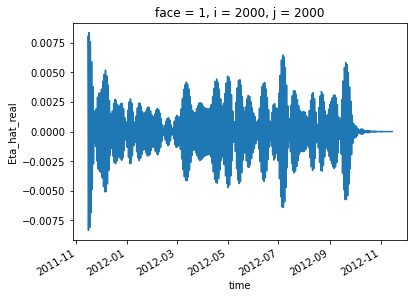

In [27]:
#dsi['Depth'] = grd.Depth.sel(**sel)

dsi.Eta_hat_real.isel(face=1).sel(i=2000,j=2000).plot()

In [9]:
def wrap_wrap(ds):
    """wrap correlation function
    """
    T = 80
    dt = 3/24
    _u = ds.Eta_demodulated_real#SSU_rot_demodulated_real
    _ui = ds.Eta_demodulated_imag#SSU_rot_demodulated_imag
#    _u = _u.chunk({'time':-1,'i':1080//4,'j':1080//4})
#    _u = ds.SSU_rot_hat-ds.SSU_rot_hat.mean('time')
    lags = np.arange(0,T//2+dt,dt)[:T//2*24+1]#[::dit]
    Crr= wrap_correlate(_u, _u,dt,lags=lags,roll=True,detrend=False, Nr=int(T/dt))#.persist()
    Cri= wrap_correlate(_u, _ui,dt,lags=lags,roll=True,detrend=False, Nr=int(T/dt))#.persist()
#    ds_out = Crr.to_dataset()
    ds_out = xr.merge([Crr.rename('Crr'),Cri.rename('Cri')])
#ds_out = ds_out.assign_coords({'XC':ds.XC,'YC':ds.YC})
#    ds_out = ds_out.chunk({'i':1080//4,'j':1080//4,'lags':-1})
#    ds_out = ds_out._reset_chunk_encoding()
    return ds_out#[['correlation']]#.drop(['lon','lat','XC','YC'])

def wrap_low(ds):
    """wrap correlation function
    """
    T = 80
    dt = 3/24
    _u = ds.Eta_hat_real_hat
#    _ui = ds.SSU_rot_demodulated_imag
#    _u = _u.chunk({'time':-1,'i':1080//4,'j':1080//4})
#    _u = ds.SSU_rot_hat-ds.SSU_rot_hat.mean('time')
    lags = np.arange(0,T//2+dt,dt)[:T//2*24+1]#[::dit]
    Crr= wrap_correlate(_u, _u,dt,lags=lags,roll=True,detrend=False, Nr=int(T/dt))#.persist()
#    Cri= wrap_correlate(_u, _ui,dt,lags=lags,roll=True,detrend=False, Nr=int(T/dt))#.persist()
#    ds_out = Crr.to_dataset()
    ds_out = Crr.rename('Crr').to_dataset()#xr.merge([Crr.rename('Crr'),Cri.rename('Cri')])
#ds_out = ds_out.assign_coords({'XC':ds.XC,'YC':ds.YC})
#    ds_out = ds_out.chunk({'i':1080//4,'j':1080//4,'lags':-1})
#    ds_out = ds_out._reset_chunk_encoding()
    return ds_out#[['correlation']]#.drop(['lon','lat','XC','YC'])

In [10]:
face=1
import os,dask
with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ds_out,zarr = ut.custom_distribute(dsi,
                                    wrap_low,
                                    overwrite=True,
                                    suffix="Eta_autocov.zarr",
                                    tmp_dir=os.path.join(ut.root_data_dir, "diags"),
                                    append=True,
    #                            op_kwargs=dict(v=v,
    #                                            with_mean=with_mean,
    #                                            N_window=T_window*24,
    #                                            dij=dij,
    #                                            ),
                                    face=face,
    #                                j=100
                                   )

13it [13:25, 61.98s/it]


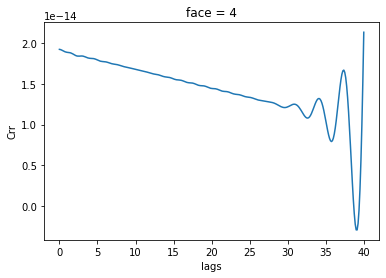

In [13]:
ds_out.Crr.mean(['i','j']).isel(face=4).plot()

In [19]:
ds = xr.concat([xr.open_zarr(ut.work_data_dir+'filtered_itide/Eta_autocov.zarr_%s'%i
                           ) for i in np.arange(0,13)],dim='face')

In [20]:
grd = xr.open_zarr(ut.work_data_dir+'rechunked/SSU_rot.zarr')[['Depth']].isel(i=slice(0,None,4),j=slice(0,None,4))
grd

/dev/shm/pbs.45480.datarmor0/ipykernel_35757/2557500697.py:1: RuntimeWarning: Failed to open Zarr store with consolidated metadata, falling back to try reading non-consolidated metadata. This is typically much slower for opening a dataset. To silence this warning, consider:
1. Consolidating metadata in this existing store with zarr.consolidate_metadata().
2. Explicitly setting consolidated=False, to avoid trying to read consolidate metadata, or
3. Explicitly setting consolidated=True, to raise an error in this case instead of falling back to try reading non-consolidated metadata.
  grd = xr.open_zarr(ut.work_data_dir+'rechunked/SSU_rot.zarr')[['Depth']].isel(i=slice(0,None,4),j=slice(0,None,4))


<xarray.Dataset>
Dimensions:  (face: 13, j: 1080, i: 1080)
Coordinates:
  * face     (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
  * i        (i) int64 0 4 8 12 16 20 24 ... 4292 4296 4300 4304 4308 4312 4316
  * j        (j) int64 0 4 8 12 16 20 24 ... 4292 4296 4300 4304 4308 4312 4316
Data variables:
    Depth    (face, j, i) float32 dask.array<chunksize=(1, 270, 270), meta=np.ndarray>

In [22]:
grd = grd.chunk({'i':72,'j':48})

In [21]:
ds

,Array,Chunk
Bytes,36.26 GiB,8.46 MiB
Shape,"(13, 1080, 1080, 321)","(1, 48, 72, 321)"
Count,8983 Tasks,4485 Chunks
Type,float64,numpy.ndarray
,Array,Chunk
Bytes,36.26 GiB,8.46 MiB
Shape,"(13, 1080, 1080, 321)","(1, 48, 72, 321)"
Count,8983 Tasks,4485 Chunks
Type,float64,numpy.ndarray


In [23]:
ds['Depth'] = grd.Depth
ds

,Array,Chunk
Bytes,36.26 GiB,8.46 MiB
Shape,"(13, 1080, 1080, 321)","(1, 48, 72, 321)"
Count,8983 Tasks,4485 Chunks
Type,float64,numpy.ndarray
,Array,Chunk
Bytes,36.26 GiB,8.46 MiB
Shape,"(13, 1080, 1080, 321)","(1, 48, 72, 321)"
Count,8983 Tasks,4485 Chunks
Type,float64,numpy.ndarray
,Array,Chunk


In [24]:
ds = ds.where(ds.Depth>500)

In [25]:
ut.store_diagnostic('Eta_autocov',ds)

data stored in /home/datawork-lops-osi/equinox/mit4320/diags/Eta_autocov.zarr


In [26]:
ds = ds.assign_coords({'XC':grd.XC.sel(**sel),'YC':grd.YC.sel(**sel)})
#ds_out['YC'] = grd.YC.isel(face=slice(0,2))

AttributeError: 'Dataset' object has no attribute 'XC'

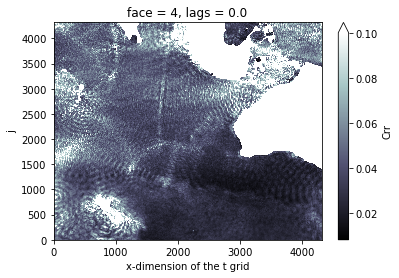

In [16]:
np.sqrt(ds.Crr.isel(lags=0)).isel(face=4).plot(vmax=0.1,cmap='bone')

/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1797: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  result = matplotlib.axes.Axes.pcolormesh(self, *args, **kwargs)
/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1797: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  result = matplotlib.axes.Axes.pcolormesh(self, *args, **kwargs)
/home1/datahome/zcaspar/miniconda3/e

{'fig': <Figure size 1080x1080 with 1 Axes>,
 'ax': <GeoAxesSubplot:title={'center':'face = 12, lags = 0.0'}, xlabel='longitude [degrees_east]', ylabel='latitude [degrees_north]'>,
 'cbar': None}

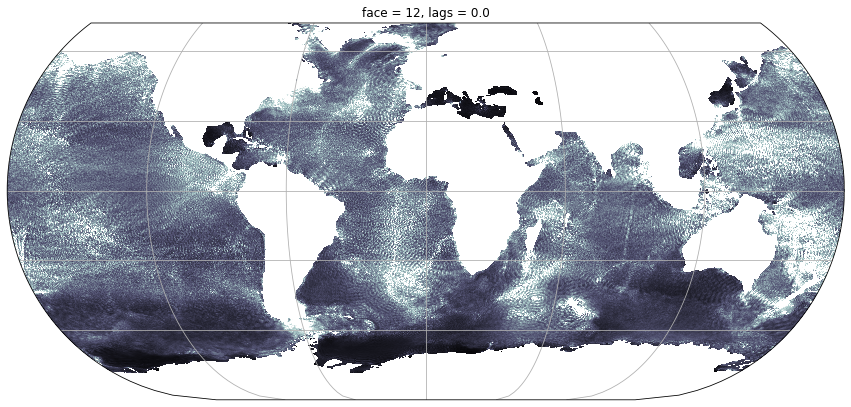

In [17]:
pl.plot_pretty(np.sqrt(ds.Crr.isel(lags=0)), 
                   infer_intervals=False,land=False,cmap='bone',vmax=0.1,colorbar=False
                  )

In [28]:
#client.restart()
#
cluster.close()

/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/contextlib.py:120: UserWarning: Creating scratch directories is taking a surprisingly long time. This is often due to running workers on a network file system. Consider specifying a local-directory to point workers to write scratch data to a local disk.
  next(self.gen)
/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/contextlib.py:120: UserWarning: Creating scratch directories is taking a surprisingly long time. This is often due to running workers on a network file system. Consider specifying a local-directory to point workers to write scratch data to a local disk.
  next(self.gen)
/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/contextlib.py:120: UserWarning: Creating scratch directories is taking a surprisingly long time. This is often due to running workers on a network file system. Consider specifying a local-directory to point workers to write scratch data to a local disk.
  next(self.gen)
/home1/